In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_excel('rajasthan_ground.xlsx')

# Drop non-numeric identifier columns
df.drop(columns=['SR', 'Name of State', 'Name of District'], inplace=True, errors='ignore')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 13 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Recharge from rainfall During Monsoon Season                          33 non-null     float64
 1   Recharge from other sources During Monsoon Season                     33 non-null     float64
 2   Recharge from rainfall During Non Monsoon Season                      33 non-null     float64
 3   Recharge from other sources During Non Monsoon Season                 33 non-null     float64
 4   Total Annual Ground Water Recharge                                    33 non-null     float64
 5   Total Natural Discharges                                              33 non-null     float64
 6   Annual Extractable Ground Water Resource                              33 non-null     


Missing values:
Recharge from rainfall During Monsoon Season                            0
Recharge from other sources During Monsoon Season                       0
Recharge from rainfall During Non Monsoon Season                        0
Recharge from other sources During Non Monsoon Season                   0
Total Annual Ground Water Recharge                                      0
Total Natural Discharges                                                0
Annual Extractable Ground Water Resource                                0
Current Annual Ground Water Extraction For Irrigation                   0
Current Annual Ground Water Extraction For Domestic & Industrial Use    0
Total Current Annual Ground Water Extraction                            0
Annual GW Allocation for Domestic Use as on 2025                        0
Net Ground Water Availability for future use                            0
Stage of Ground Water Extraction (%)                                    0
dtype: int64

Descrip

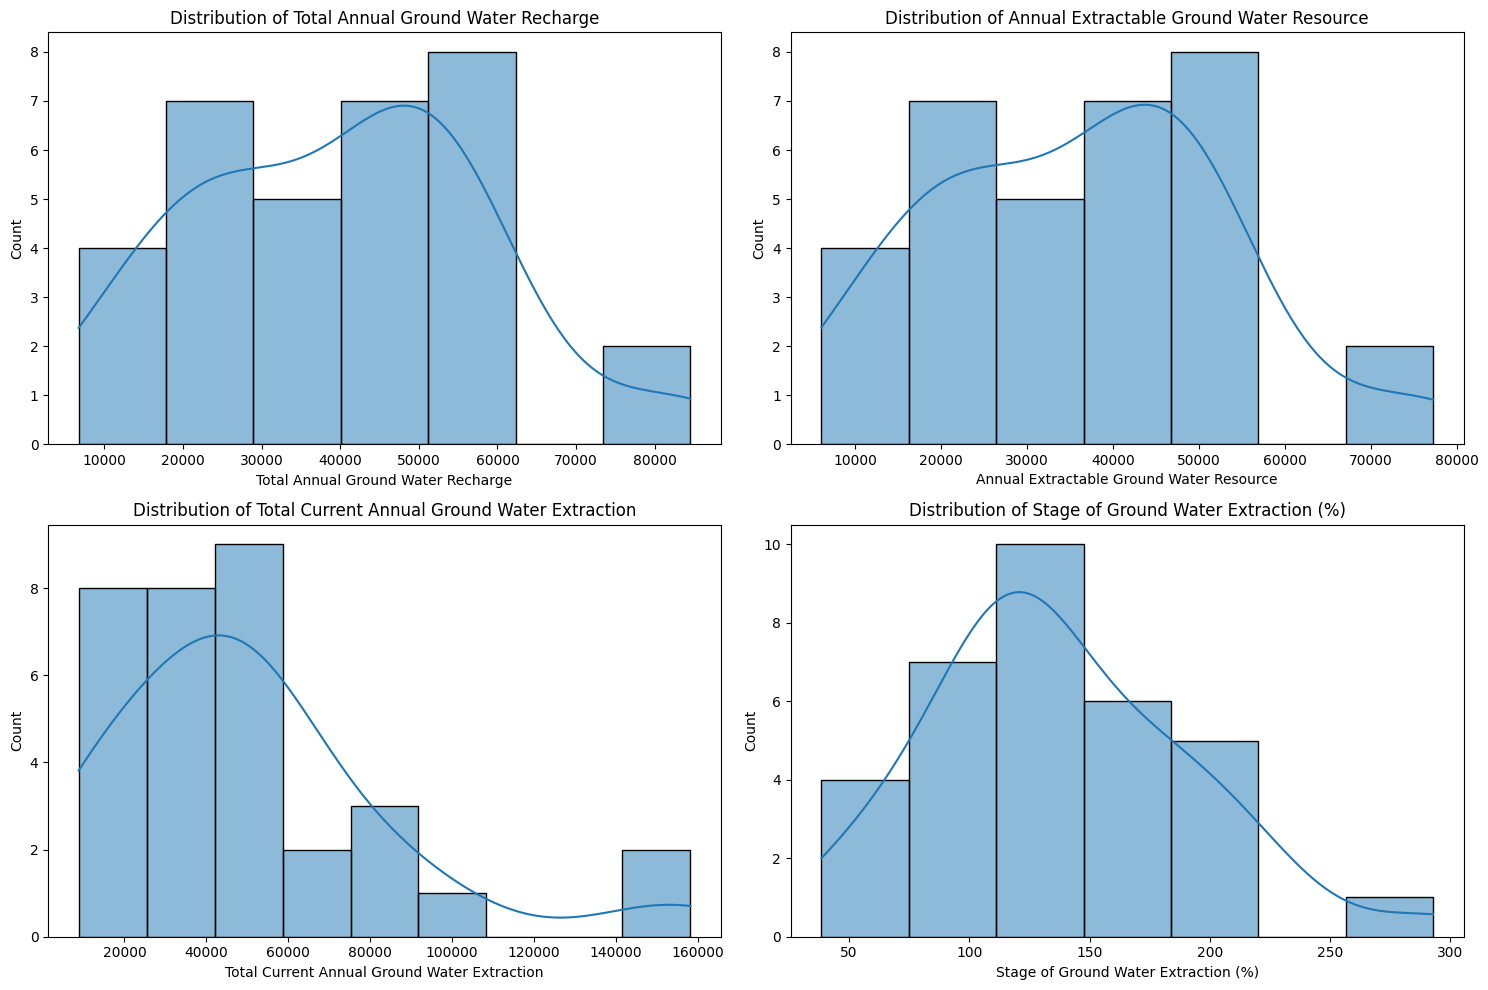

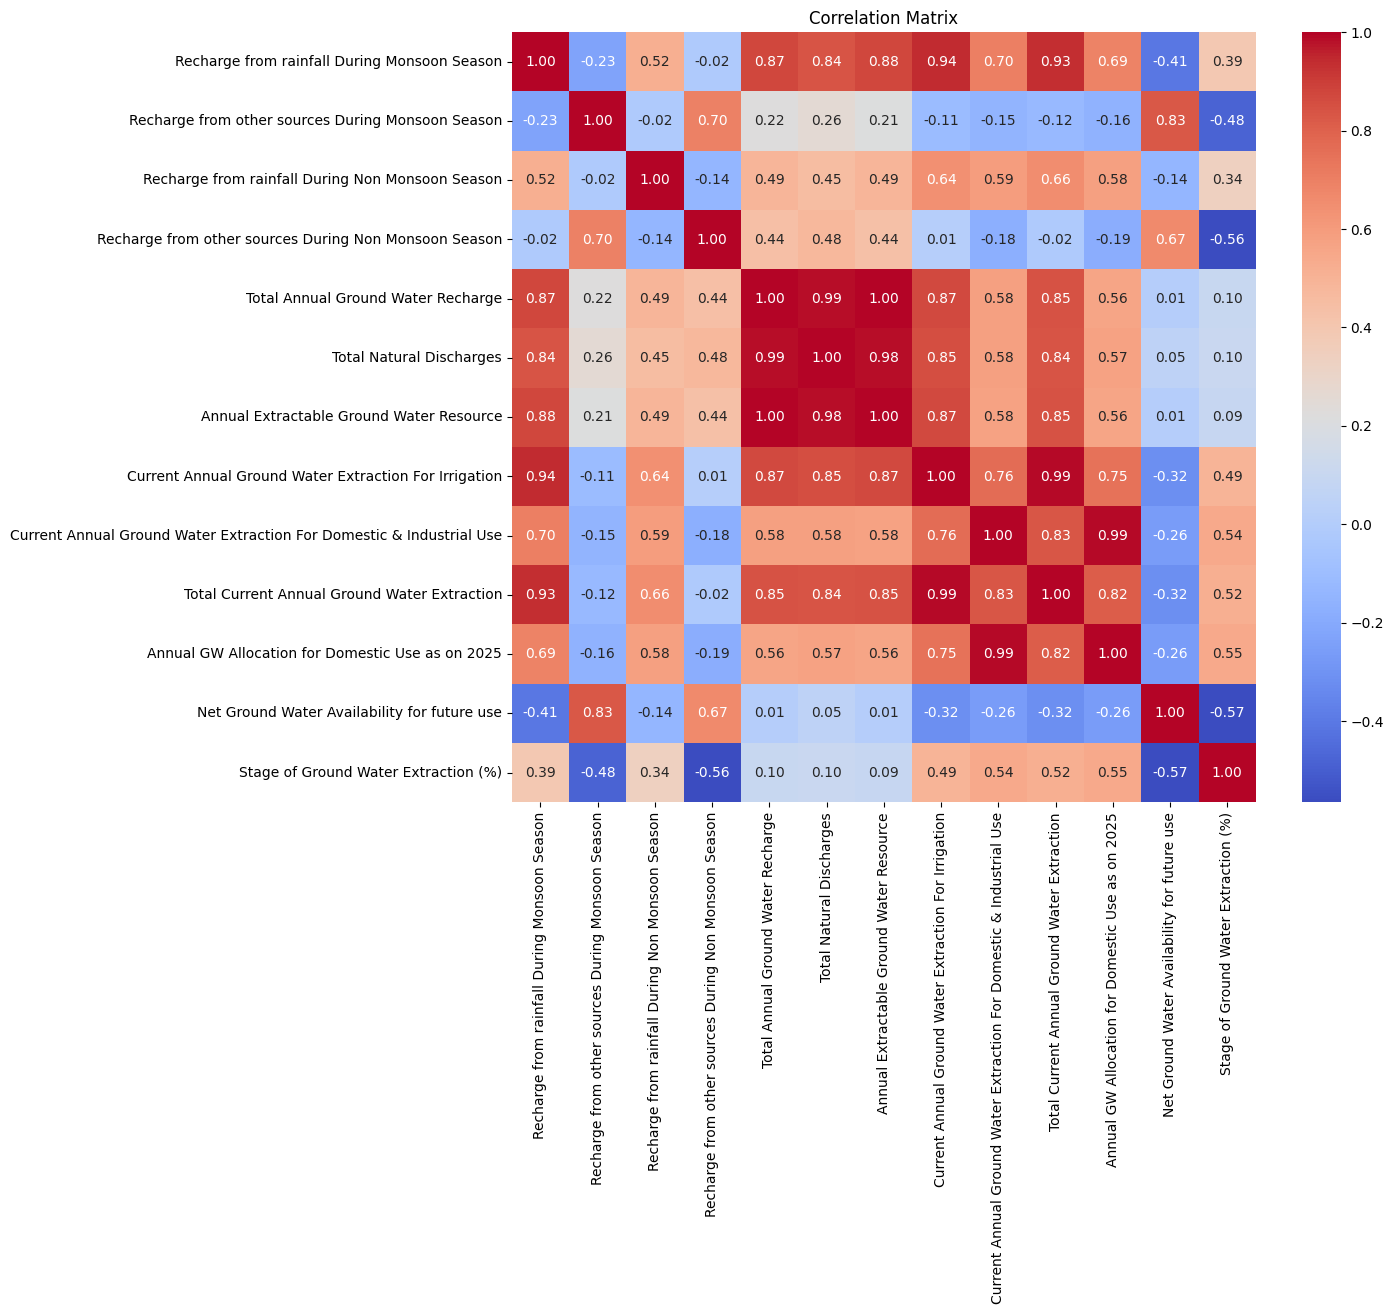

In [ ]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics
print("\nDescriptive statistics:")
print(df.describe())

# Visualize the distribution of key variables
plt.figure(figsize=(15, 10))
features = ['Total Annual Ground Water Recharge',
            'Annual Extractable Ground Water Resource',
            'Total Current Annual Ground Water Extraction',
            'Stage of Ground Water Extraction (%)']
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Model Performance:
RMSE: 3369.26
R2 Score: 0.29


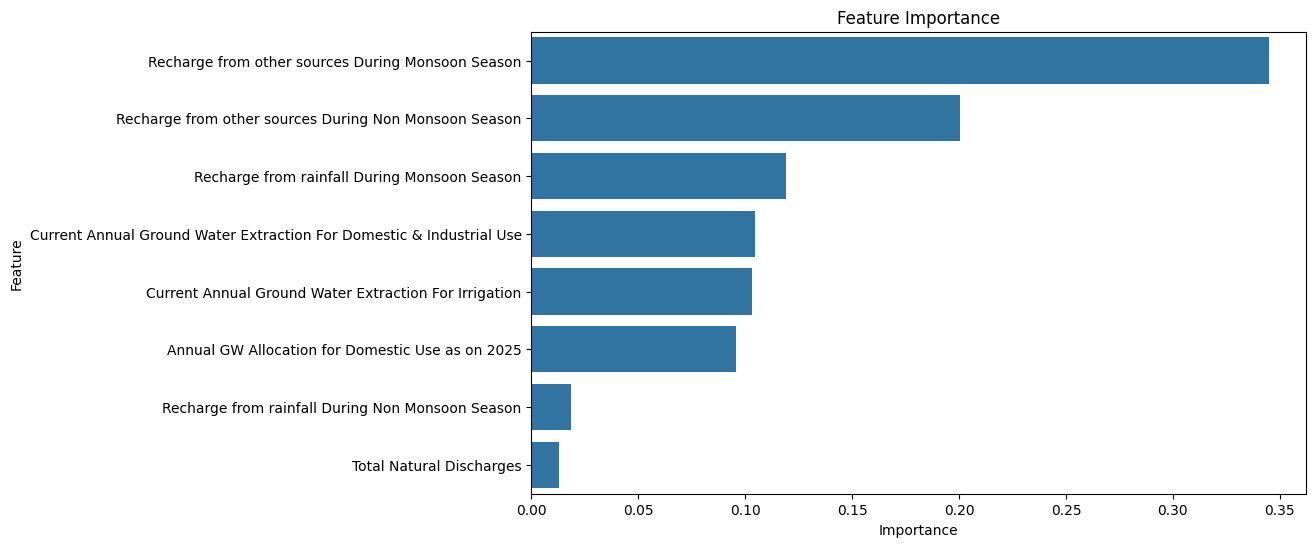

In [ ]:
# Prepare data for modeling
df['Critical Status'] = np.where(df['Net Ground Water Availability for future use'] <= 0, 1, 0)

# Features selection
features = ['Recharge from rainfall During Monsoon Season',
           'Recharge from other sources During Monsoon Season',
           'Recharge from rainfall During Non Monsoon Season',
           'Recharge from other sources During Non Monsoon Season',
           'Total Natural Discharges',
           'Current Annual Ground Water Extraction For Irrigation',
           'Current Annual Ground Water Extraction For Domestic & Industrial Use',
           'Annual GW Allocation for Domestic Use as on 2025']

target = 'Net Ground Water Availability for future use'

# Split data
X = df[features]
y = df[target]

# Handle districts with negative/zero availability
y = y.apply(lambda x: 0.1 if x <= 0 else x)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Feature importance
importances = pipeline.named_steps['model'].feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

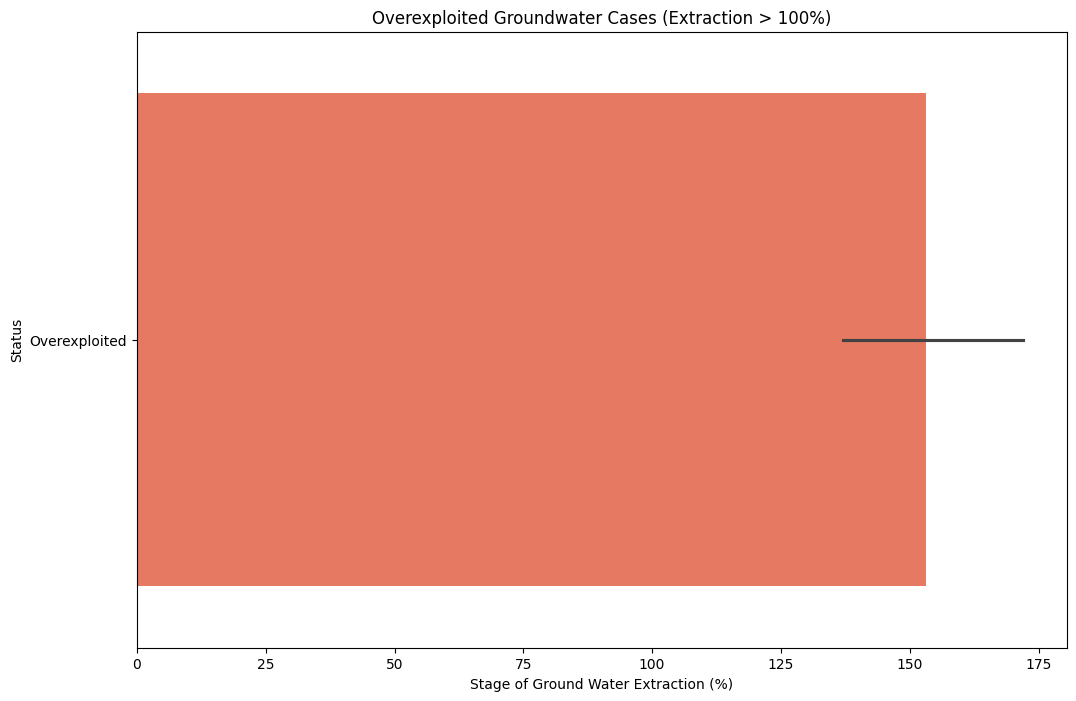

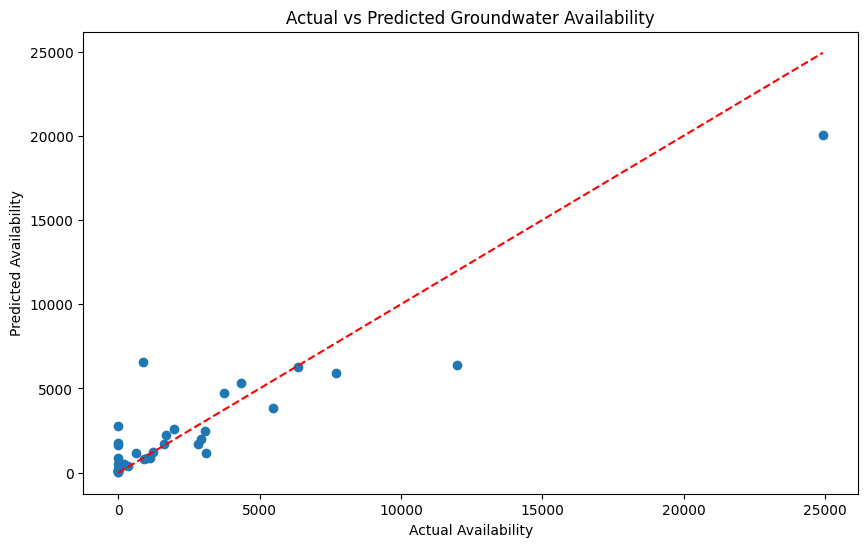

In [ ]:
# Analyze all data points
df['Predicted Availability'] = pipeline.predict(X)
df['Extraction Status'] = df['Stage of Ground Water Extraction (%)'].apply(
    lambda x: 'Overexploited' if x > 100 else 'Safe')

# Visualize critical cases
plt.figure(figsize=(12, 8))
critical = df[df['Extraction Status'] == 'Overexploited']
sns.barplot(x='Stage of Ground Water Extraction (%)', y='Extraction Status',
            data=critical, palette='Reds_r')
plt.title('Overexploited Groundwater Cases (Extraction > 100%)')
plt.xlabel('Stage of Ground Water Extraction (%)')
plt.ylabel('Status')
plt.show()

# Compare actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(df['Net Ground Water Availability for future use'], df['Predicted Availability'])
plt.plot([df['Net Ground Water Availability for future use'].min(),
          df['Net Ground Water Availability for future use'].max()],
         [df['Net Ground Water Availability for future use'].min(),
          df['Net Ground Water Availability for future use'].max()], 'r--')
plt.xlabel('Actual Availability')
plt.ylabel('Predicted Availability')
plt.title('Actual vs Predicted Groundwater Availability')
plt.show()

In [ ]:
# Save the model
import joblib
joblib.dump(pipeline, 'groundwater_model.pkl')

# To load the model later:
# loaded_model = joblib.load('groundwater_model.pkl')

['groundwater_model.pkl']